# 2017-10-18
# A. Pendleton
# Re-processing the first round of FST CDRs using the Total SNP Set. 

In [1]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles

def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)

In [2]:
chromToDo = []
for num in range(1,39):
    chr = 'chr' + str(num)
    chromToDo.append(chr)
chromToDo.append('chrX')

In [3]:
inDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/'

In [4]:
#Write bedfile for subsequent intersections 
fstFile = inDir + 'input/' + 'AutoXParXNonPar_Sliding_TotalSIGFstCalls_54callset_mxbRemoved_GeneTable.txt'
bedFile = open(inDir + 'input/' + 'AutoXParXNonPar_Sliding_TotalSIGFstCalls_54callset_mxbRemoved.bed', 'w')

for line in open(fstFile, 'r'):
    if 'Chrom' in line: #skips header
        continue
    line=line.rstrip().split('\t')
    chrom,start,end,ID,AverageROA, AverageZ = line[0], int(line[1])-1, int(line[2]), line[3], float(line[7]), float(line[9])
    bedFile.write('%s\t%i\t%i\t%s\t%f\t%f\n' % (chrom,start,end,ID, AverageROA, AverageZ))
bedFile.close()

########################################################################################

In [5]:
def do_intersects(a, b, outfile):
    cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (a, b, outfile)
    #print(cmd)
    runCMD(cmd)
    Dict = process_intersect(outfile)
    return Dict
def process_intersect(outfile):
    Dict={}
    for line in open(outfile,'r'):
        line=line.rstrip().split()
        chrom,start,end,ID = line[0:4]
        hitID = line[9]
        if ID in Dict.keys():
            Dict[ID].append(hitID)
        else:
            Dict[ID] = []
            Dict[ID].append(hitID)
    return Dict
def gene_intersects(a,b,intersectfile):
    #cmd = 'bedtools intersect -wo -a %s -b %s > %s' % (a, b, outfile)
    cmd = 'bedtools window -w 50000 -a %s -b %s > %s' % (a, b, outfile)
    runCMD(cmd)
    
    b2goDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/results/BLAST2GO/'
    # going through Ensembl bedtool intersect results file
    ensGDict = {} #ensGDict[windowID] = [gene1,gene2,gene3...]
    ensID = ''
    sigGenes = [] #To keep track of all gene IDs (ENSCAFG) that are in sig windows

    for line in open(intersectfile,'r'):
        line = line.rstrip().split('\t')
        winID = line[3]
        hit = line[9].split('_')
        Protein = hit[0]
        Gene = hit[1]
        b2goID = Gene + '|' + Protein
        ensGID = hit[2]
        if winID in ensGDict:
            ensGDict[winID].append(ensGID)
        else:
            ensGDict[winID] = []
            ensGDict[winID].append(ensGID) 
            sigGenes.append(b2goID)
    return ensGDict

In [6]:
resultsDir = inDir + 'results/'
#Our merged CDRs
cdrfile = inDir + 'input/' + 'AutoXParXNonPar_Sliding_TotalSIGFstCalls_54callset_mxbRemoved.bed'

#Get ensembl gene intersects -- save to Dict
genebedfile = '/home/ampend/links/kidd-lab/ampend-projects/BLAST2GO/results/BLAST2GO_Ensembl81_GeneTables_WithEnscafIDsAndChrom.bed'
outfile = resultsDir + 'Intersect_PrimaryCDRs_with_EnsemblGenes_50kbIntersectWindow.txt'
ensGDict = gene_intersects(cdrfile, genebedfile, outfile)
#Get Axelsson loci intersects -- save to Dict
axelssonBedFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/results/Axelsson_CaganBlass/input/Axelsson_canfam3.1.bed'
outfile = resultsDir + 'Intersect_PrimaryCDRs_with_AxelssonLoci.txt'
axDict = do_intersects(cdrfile, axelssonBedFile, outfile)
#Get CaganBlass loci intersects -- save to Dict
caganBlassBedFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/results/Axelsson_CaganBlass/input/CaganBlass_canfam3.1.bed '
outfile = resultsDir + 'Intersect_PrimaryCDRs_with_CaganBlassLoci.txt'
cbDict = do_intersects(cdrfile, caganBlassBedFile, outfile)

In [7]:
cdrFile = open(cdrfile, 'r')
cdrCount = 0
allDict = {}

for line in cdrFile:
    if 'Chrom' in line:
        continue
    line=line.rstrip().split('\t')
    cdrCount += 1
    chrom, start_pos, end_pos, WinID, Fst,Z = line[0:6]
    winLength = int(end_pos) - int(start_pos) + 1
    winCoord = chrom + ":" + str(start_pos) + "-" + str(end_pos)
    #Open up dictionary for WinID
    #0=chr, 1=start_pos, 2=end_pos, 3=WinID, 4=Window length, 5=WindowCoordinates(forUCSC)
    #6=RofA_WindowAverage_Fst #7 = Average_Z_Score_For_MergedWindow
    #8=Intersects with Ensembl Gene IDs (default = False)
    #9=Intersects with Axelsson Loci (default = False)
    #10=Intersects with Cagan/Blass Loci (default = False)
    allDict[WinID] = [chrom,start_pos,end_pos,WinID,winLength,winCoord,Fst,Z,'','',''] #setting up empty dictionary
    #Did this CDR intersect with a gene?
    if WinID in ensGDict: #If this window is in the ensembl list you generated, then...:
        y = ", ".join(map(str, ensGDict[WinID])) #This takes the list you generated from the Ensembl file and joins each entry in the list with a comma
        allDict[WinID][8] = y #Now it adds 'y' you generated in the line above to your dictionary
    #Did this CDR intersect with a gene?
    if WinID in axDict: #If this window is in the ensembl list you generated, then...:
        y = ", ".join(map(str, axDict[WinID])) #This takes the list you generated from the Ensembl file and joins each entry in the list with a comma
        allDict[WinID][9] = y #Now it adds 'y' you generated in the line above to your dictionary
    #Did this CDR intersect with a gene?
    if WinID in cbDict: #If this window is in the ensembl list you generated, then...:
        y = ", ".join(map(str, cbDict[WinID])) #This takes the list you generated from the Ensembl file and joins each entry in the list with a comma
        allDict[WinID][10] = y #Now it adds 'y' you generated in the line above to your dictionary
    allDict[WinID][3] = WinID.replace('FST','CDR')  #now we can call them CDRs instead of FST
    
#Sorts a dictionary's alphanumeric keys
def key_func(s):
    return [int(x) if x.isdigit() else x for x in re.findall(r'\D+|\d+', s)]
sorted_keys = sorted(allDict, key=key_func)

outFile = open(resultsDir + 'SummaryTable_PrimaryCDRs_Genes_Axelsson_CaganBlass.txt','w')
for key in sorted_keys: #Now loops through each 
    print ("\t".join(map(str,allDict[key])))
    outFile.write("\t".join(map(str,allDict[key])))
    outFile.write("\n")
outFile.close()

chr1	2350000	3250000	CDR_1	900001	chr1:2350000-3250000	0.564374	5.992389	GALR1, MBP, ZNF236	AX_1	CB_1, CB_2
chr1	79800000	80150000	CDR_2	350001	chr1:79800000-80150000	0.557803	5.897154	ENSCAFG00000030357	AX_4	
chr3	18800000	19050000	CDR_3	250001	chr3:18800000-19050000	0.514167	5.264731		AX_7	
chr4	40800000	41000000	CDR_4	200001	chr4:40800000-41000000	0.512679	5.243158	TLX3, ENSCAFG00000016912, RANBP17	AX_10	
chr5	3850000	4250000	CDR_5	400001	chr5:3850000-4250000	0.539992	5.639010	SNX19		
chr6	39900000	40100000	CDR_6	200001	chr6:39900000-40100000	0.523042	5.393353	HAGHL, CCDC78, NARFL, METRN, WDR24, FBXL16, RHBDL1, RHOT2, FAM195A, WFIKKN1, PRR35, NHLRC4, CAPN15, ENSCAFG00000032180, ENSCAFG00000019677, DECR2, MRPL28, C16orf13, WDR90, JMJD8, STUB1, RAB11FIP3, TMEM8A, PIGQ		
chr6	40350000	40600000	CDR_7	250001	chr6:40350000-40600000	0.515529	5.284464	ENSCAFG00000032615, ENSCAFG00000031055, HBM, ENSCAFG00000029904, ENSCAFG00000028569, ENSCAFG00000024468, ENSCAFG00000028465, MPG, SNRNP25, EN

In [ ]:
cdrfile = real_finalResultsDir + 'MergedOverlapping_Sliding_TotalSIGFstCalls_AutoXPar_54callset.bed'
cdrFile = open(cdrfile, 'r')
cdrCount = 0
allDict = {}

for line in cdrFile:
    if 'Chrom' in line:
        continue
    line=line.rstrip().split('\t')
    cdrCount += 1
    chrom, start_pos, end_pos, WinID, Fst = line[0:5]
    winLength = int(end_pos) - int(start_pos) + 1
    winCoord = chrom + ":" + str(start_pos) + "-" + str(end_pos)
    #Open up dictionary for WinID
    #0=chr, 1=start_pos, 2=end_pos, 3=WinID, 4=Window length, 5=WindowCoordinates(forUCSC)
    #6=RofA_WindowAverage_Fst
    #7=Intersects with an XP-CLR CDR (default = False), 
    #8=Intersects with Ensembl Gene IDs (default = False)
    #9=Intersects with Axelsson Loci (default = False)
    #10=Intersects with Cagan/Blass Loci (default = False)
    allDict[WinID] = [chrom,start_pos,end_pos,WinID,winLength,winCoord,Fst,'','','',''] #setting up empty dictionary
    #Did this CDR intersect with an XPCLR sweep?
    if WinID in xpclrDict: #If this window is in the ensembl list you generated, then...:
        y = ", ".join(map(str, xpclrDict[WinID])) #This takes the list you generated from the Ensembl file and joins each entry in the list with a comma
        allDict[WinID][7] = y #Now it adds 'y' you generated in the line above to your dictionary
    #Did this CDR intersect with a gene?
    if WinID in ensGDict: #If this window is in the ensembl list you generated, then...:
        y = ", ".join(map(str, ensGDict[WinID])) #This takes the list you generated from the Ensembl file and joins each entry in the list with a comma
        allDict[WinID][8] = y #Now it adds 'y' you generated in the line above to your dictionary
    #Did this CDR intersect with a gene?
    if WinID in axDict: #If this window is in the ensembl list you generated, then...:
        y = ", ".join(map(str, axDict[WinID])) #This takes the list you generated from the Ensembl file and joins each entry in the list with a comma
        allDict[WinID][9] = y #Now it adds 'y' you generated in the line above to your dictionary
    #Did this CDR intersect with a gene?
    if WinID in cbDict: #If this window is in the ensembl list you generated, then...:
        y = ", ".join(map(str, cbDict[WinID])) #This takes the list you generated from the Ensembl file and joins each entry in the list with a comma
        allDict[WinID][10] = y #Now it adds 'y' you generated in the line above to your dictionary
    allDict[WinID][3] = WinID.replace('FST','CDR')  #now we can call them CDRs instead of FST
    
#Sorts a dictionary's alphanumeric keys
def key_func(s):
    return [int(x) if x.isdigit() else x for x in re.findall(r'\D+|\d+', s)]
sorted_keys = sorted(allDict, key=key_func)

outFile = open(real_finalResultsDir + 'SummaryTable_CDRs_Genes_XPCLR_Axelsson_CaganBlass.txt','w')
for key in sorted_keys: #Now loops through each 
    print ("\t".join(map(str,allDict[key])))
    outFile.write("\t".join(map(str,allDict[key])))
    outFile.write("\n")
outFile.close()

####################################################################################################

# Draw Venn Diagrams of Primary CDRs with Axelsson/CaganBlass

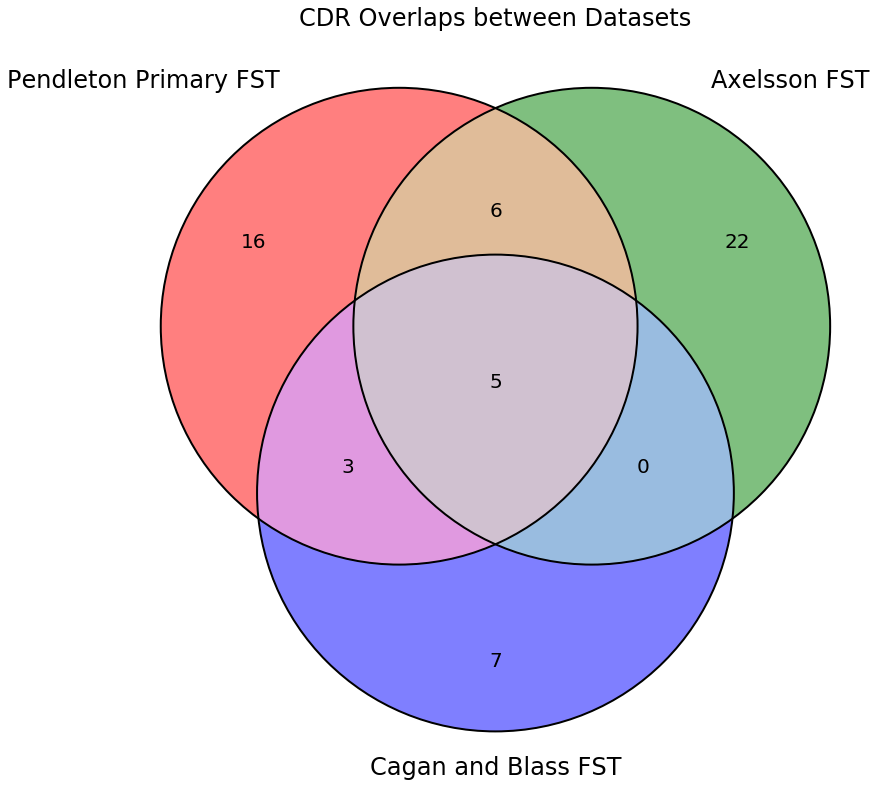

In [21]:
font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 20}
plt.rc('font', **font)

plt.figure(figsize=(14,14))
s = (1,1,1,1,1,1,1)
v = venn3(subsets = s, set_labels = ('Pendleton Primary FST', 'Axelsson FST', 'Cagan and Blass FST'))
#Pendleton FST Only
v.get_patch_by_id('100').set_alpha(.50)
v.get_label_by_id('100').set_text('16')

#Axelsson Only
v.get_patch_by_id('010').set_alpha(.50)
v.get_label_by_id('010').set_text('22')

#CB Only
v.get_patch_by_id('001').set_alpha(.50)
v.get_label_by_id('001').set_text('7')

#Pendleton  - Axelsson
v.get_label_by_id('110').set_text('6') 

#Pendleton  - CB 
v.get_label_by_id('101').set_text('3') 

#CB - Axelsson 
v.get_label_by_id('011').set_text('0') 

#All (Kidd-CB-AX)
v.get_patch_by_id('111').set_alpha(.30)
v.get_label_by_id('111').set_text('5')

#Determining circle outlines
c = venn3_circles(subsets=s, linestyle='solid')
c[0].set_lw(2.0)
c[1].set_lw(2.0)
c[2].set_lw(2.0)
plt.title("CDR Overlaps between Datasets",fontsize=24)
plt.show()

####################################################################################################

# Making genotype matrices for the Primary CDRs Only

In [94]:
#For making the genotype matrices
scriptDir = inDir + 'GenotypeMatrices/scripts/' 
cmdFile = open(scriptDir + 'Plink_ExtractSNPCommands.cmds','w')
#Required for plink command
outDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/'
cdrfile = cdrfile

plink_extract_snps(outDir,cmdFile,cdrfile)
write_convertf_commands(outDir)

In [93]:
def plink_extract_snps(outDir,cmdFile,cdrfile):
    keepSNPFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/TotalSNPSet_ToKeep_PerSite.txt'
    bimFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/input/CDRExtracted_89sample_ancient_Freedman_Lcu2_TotalSNPSet'

    for line in open(cdrfile,'r'):
        line=line.rstrip().split('\t')
        chrom,start,end, ID = line[0:4]
        if 'chrX' in chrom:
            continue
        outFile = outDir + ID + '_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix'
        cmd = 'plink-1.90 --dog --maf 0.05 --geno 0 --max-maf 0.49 --extract %s --bfile %s --chr %s --from-bp %s --to-bp %s --make-bed --out %s' % (keepSNPFile,bimFile, chrom, start, end, outFile)
        runCMD(cmd)
        cmdFile.write('%s\n'%cmd)
    cmdFile.close()
########################################################################################################
def write_convertf_commands(outDir):
    #GENERATING THE CONVERTF COMMANDS TO MAKE EIGENSTRAT GENO FILES
    cmdfile = outDir + 'convertf_commands.cmds'
    cmdFile = open(cmdfile, 'w')
    #CHECK THIS!!!!
    #Each of my files had filt in the file names and were bed files. You need to change this 
    #	line to make sure that you are capturing all the bed files generated from the 
    #	commands written from the make_bed.py script
    for file in glob.glob(outDir + '*bed'): #May need to change this to whatever consistent naming you have for all of your bed (PLINK) files (i.e. CDR, FST, filt, etc.)
        name=file.replace('.bed','')
        name=name.replace(outDir,'')
        f1=open(outDir + 'par_%s.convertf' %(name),"w")

        #CHECK THIS!!!!!
        #This needs to be the original, full SNP file that you originally used the make_bed.py
        #	script to pull the SNPs out of (your .bim file)
        f1.write("indivname:\t89sample_ancient_Freedman_Lcu2_all_GF_filter_geno0.ind\n") 

        f1.write("snpname:\t%s.bim\n" %(name))
        f1.write("genotypename:\t%s.bed\n" %(name))
        f1.write("outputformat:\tEIGENSTRAT\n")
        f1.write("genotypeoutname:\t%s.eigenstratgeno\n" %(name))
        f1.write("snpoutname:\t%s.snp\n" %(name))
        f1.write("indoutname:\t%s.ind\n" %(name))
        f1.write("familynames:\tNO\n")
        #This script will now write out commands to a command file called convert.cmds in 
        #the directory where you are running this script. You'll have to run the commands later.
        #But this command is calling a program that Shiya has installed in the software
        #directory of her own directory. Just make sure to remember to run the command file, haha.
        #cmds='/home/songsy/softwares/AdmixTools/src/convertf -p par_%s.convertf' %(name) 
        cmd = '/home/ampend/links/kidd-lab/progs/eigensoft/bin/convertf -p %spar_%s.convertf' % (outDir,name)
        cmdFile.write('%s\n'%(cmd))
        f1.close()
    cmdFile.close()

    cmd = 'chmod 777 %s' % cmdfile
    runCMD(cmd)

In [85]:
fHD_array = []
sample_array = []
sample_array.append('SNP_ID')

#Generating the row column IDs based on the sample  names
sampleFile = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/desc.txt'
for line in open(sampleFile,'r'):
    line = line.split()
    if '#' in line[0]:
        continue
    sampleID = line[0]
    sample_array.append(sampleID)

windowCount = 0 
for file in glob.glob(outDir+"*.eigenstratgeno"):
    print (file)
    name=file.replace(".eigenstratgeno","")
    FH=open(file, 'r')
    windowCount+=1
    outfile = name + '_forMatrix.txt'
    outFile = open(outfile, 'w')
    print ('Writing new matrix to', outfile)

    bimfile = name + '.bim'
    snpList = []
    for line in open(bimfile, 'r'):
        line = line.split()
        snpList.append(line[1])
        lenSNP = len(snpList)
        snp = '\n'.join(map(str,snpList))
    outFile.write("#SampleID\t"+"\t".join(map(str,snpList))+"\n")

    lineNum = 0
    array=[]
    for line in FH:
        lineNum += 1
        line=list(line.rstrip())
        for i in range(0,len(line)):
            if '9' in line[i]:
                line[i] = '-'
        array.append(line)

    print ('Generated transposed matrix for %i SNPs' % (lineNum))
    if lineNum < 10:
        skip = True
    matrix=np.array(array)
    print ('matrix dimensions', matrix.shape)
    print (matrix)
    new_matrix=matrix.T
    print ('new matrix dimensions', new_matrix.shape)
    if skip is True:
        for i in range(len(new_matrix)):
            outFile.write(sample_array[i+1]+"\t"+"\t".join(map(str,new_matrix[i]))+"\n")
    else:
        print('deleting FH matrix file')
        cmd = 'rm %s' % outfile
        runCMD(cmd)

/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/FST_8_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix.eigenstratgeno
Writing new matrix to /home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/FST_8_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix_forMatrix.txt
Generated transposed matrix for 415 SNPs
matrix dimensions (415, 99)
[['0' '0' '0' ..., '2' '1' '0']
 ['0' '0' '0' ..., '0' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']
 ..., 
 ['0' '0' '0' ..., '2' '2' '0']
 ['0' '0' '0' ..., '2' '2' '0']
 ['0' '0' '0' ..., '1' '1' '0']]
new matrix dimensions (99, 415)
/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/FST_7_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix.eigenstratgeno
Writing new matrix to /home/ampen

Generated transposed matrix for 91 SNPs
matrix dimensions (91, 99)
[['0' '1' '0' ..., '2' '2' '0']
 ['0' '0' '0' ..., '2' '2' '0']
 ['0' '0' '0' ..., '2' '2' '0']
 ..., 
 ['0' '0' '0' ..., '1' '2' '0']
 ['0' '0' '0' ..., '1' '2' '0']
 ['0' '0' '0' ..., '1' '2' '0']]
new matrix dimensions (99, 91)
/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/FST_13_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix.eigenstratgeno
Writing new matrix to /home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/FST_13_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix_forMatrix.txt
Generated transposed matrix for 174 SNPs
matrix dimensions (174, 99)
[['2' '0' '0' ..., '1' '0' '1']
 ['2' '1' '0' ..., '2' '2' '2']
 ['2' '1' '0' ..., '0' '0' '2']
 ..., 
 ['0' '0' '2' ..., '1' '1' '0']
 ['0' '1' '0' ..., '0' '1' '0']
 ['0' '0' '0'

matrix dimensions (142, 99)
[['0' '0' '0' ..., '0' '0' '0']
 ['0' '0' '0' ..., '2' '0' '0']
 ['0' '2' '0' ..., '0' '0' '0']
 ..., 
 ['0' '0' '0' ..., '0' '0' '0']
 ['0' '1' '0' ..., '0' '0' '0']
 ['1' '1' '0' ..., '0' '0' '2']]
new matrix dimensions (99, 142)
/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/FST_24_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix.eigenstratgeno
Writing new matrix to /home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/FST_24_ExtractedSNPs_MAF05-49_geno0_ForGenotypeMatrix_forMatrix.txt
Generated transposed matrix for 43 SNPs
matrix dimensions (43, 99)
[['0' '0' '0' ..., '0' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']
 ..., 
 ['0' '0' '0' ..., '0' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']
 ['0' '0' '0' ..., '0' '0' '0']]
new matrix dimension

In [88]:
#sorts the matrices
cmd = 'for file in $(ls %s*forMatrix.txt); do cat "$file" | awk \'NR<2{print $0;next}{print $0| "sort"}\' > "$file"_sorted; sed -i \'s/#//g\' "$file"_sorted; done;' % (outDir)
runCMD(cmd)
print(cmd)
###DONT KNOW WHY THIS ISNT WORKING --- DO THIS IN TERMINAL ####

for file in $(ls /home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/ReProcessing_PrimaryCDRs_AxelssonMethods/GenotypeMatrices/results/*forMatrix.txt); do cat "$file" | awk 'NR<2{print $0;next}{print $0| "sort"}' > "$file"_sorted; sed -i 's/#//g' "$file"_sorted; done;


In [89]:
#Generating the plots with matrix2png
for file in glob.glob(outDir+"*_sorted"):
    cmd = 'matrix2png -data %s -mincolor blue -midcolor white -maxcolor orange -r -c -g -size 20:20 -minsize 4000:2000 > %s.png' % (file,file)
    runCMD(cmd)
print('DONE!')


DONE!


# Making genotype matrices for the Axelsson/CaganBlass CDRs Only

################################################################################################################

In [23]:
#Per Site FST Data
perSiteDir = '/home/ampend/links/kidd-lab/ampend-projects/Angela/Re-RunningAnalysis_NewScripts/new_results/Total_54callset_MxbRemoved/PerSite/'
perSiteFile = perSiteDir + 'Merged_VillageWolf_mxb_rm_PERSITE_54callset_AutoXParXNonPar_Hudson_Fst_PerSite_Zscores.txt'
perSiteList = []
perSiteHighZFst = [] #For those that have a high ZFst, will be used for plotting the bar charts later

keepTotalSNPs = open(inDir + 'TotalSNPSet_ToKeep_PerSite.txt','w')
keepHighFstTotalSNPs = open(inDir + 'HighFST_TotalSNPSet_ToKeep_PerSite.txt','w')
for line in open(perSiteFile,'r'):
    line=line.rstrip().split('\t')
    if 'CHROM' in line[0]:#skips header
        continue
    chrom,site,Fst,ZFst = line[0],int(line[1]),float(line[2]),float(line[3])
    perSiteList.append([chrom,site,Fst,ZFst])
    keepTotalSNPs.write('%s:%s\n' % (chrom,site))
    if 'chrX' not in chrom and ZFst >= 5.0:
        perSiteHighZFst.append([chrom,site,Fst,ZFst])
        keepHighFstTotalSNPs.write('%s:%s\n' % (chrom,site))
    if 'chrX' in chrom and ZFst >= 3.0:
        perSiteHighZFst.append([chrom,site,Fst,ZFst])        
        keepHighFstTotalSNPs.write('%s:%s\n' % (chrom,site))        
print('%i per site FST data points added to total perSite array' % len(perSiteList))
print('%i per site FST data points added to high ZFst only perSite array' % len(perSiteHighZFst))
keepTotalSNPs.close()
keepHighFstTotalSNPs.close()

7315882 per site FST data points added to total perSite array
21307 per site FST data points added to high ZFst only perSite array


####################################################################################################

In [ ]:
for i in perSiteHighZFst:
    